<p align="center">
    <img src="assets/dataset-cover.jpg" >
</p>

# SMS Spam Detection with Machine Learning


## Quick navigation

* [1. Description](#1.-Description)
* [2. Requirements](#2.-Requirements)
* [3. Data Analysis and Feature Engineering](#3.-Data-Analysis-and-Feature-Engineering)
* [4. Data preprocessing](#4.-Data-preprocessing)
* [5. Classic ML](#5.-Classic-ML)
* [6. LSTM](#6.-LSTM)
* [7. References](#7.-References)


## 1. Description

The SMS Ham-Spam detection dataset is a set of SMS tagged messages that have been collected for SMS Spam research. It contains a set of 5,574 SMS messages in English, considering both train and test data. The tagging standard was defined as `ham` (legitimate) or `spam`. 

The `train` and `test` files are formatted using the standard of one message per line. Each line is composed by two columns: one with label (`ham` or `spam`) and other with the raw text. Here are some examples:

```
ham   What you doing?how are you?
ham   Ok lar... Joking wif u oni...
ham   dun say so early hor... U c already then say...
ham   MY NO. IN LUTON 0125698789 RING ME IF UR AROUND! H*
ham   Siva is in hostel aha:-.
ham   Cos i was out shopping wif darren jus now n i called him 2 ask wat present he wan lor. Then he started guessing who i was wif n he finally guessed darren lor.
spam   FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! ubscribe6GBP/ mnth inc 3hrs 16 stop?txtStop
spam   Sunshine Quiz! Win a super Sony DVD recorder if you canname the capital of Australia? Text MQUIZ to 82277. B
spam   URGENT! Your Mobile No 07808726822 was awarded a L2,000 Bonus Caller Prize on 02/09/03! This is our 2nd attempt to contact YOU! Call 0871-872-9758 BOX95QU
```

    Note: messages are not chronologically sorted.

For evaluation purposes, the `test` dataset does not prosent the categories (`ham`, `spam`). Therefore, the `train` data is the full source of information for this test.

The goal of the this test is to achieve a model that can correctly manage the incoming messages on SMS format (`ham` or `spam`). Considering a real scenario, assume that a regular person does not want to see a `spam` message. However, they accepts if a normal message (`ham`) is sometimes allocated at the `spam` box.

## 2. Requirements

Assuming that you have a clean enviroment to run this jupyter notebook, create a new code block, copy and paste the following code and run it:

```py
!pip install numpy
!pip install matplotlib
!pip install tensorflow
!pip install scikit-learn
!pip install nltk
!pip install transformers
!pip install seaborn
!pip install xgboost
```

In [1]:
#################################################################################################

import re
from collections import Counter
import time

#################################################################################################

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#################################################################################################

from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from transformers import TFTrainer, TFTrainingArguments
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier

#################################################################################################

import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#################################################################################################

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model, layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

#################################################################################################

gpu = len(tf.config.list_physical_devices('GPU'))>0

if gpu:
    print("GPU is", "available")
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("NOT AVAILABLE")

GPU is available


In [2]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /home/jpvt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jpvt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jpvt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 3. Data Analysis and Feature Engineering

In [3]:
TRAIN_PATH = 'TrainingSet/sms-hamspam-train.csv'

df = pd.read_csv(TRAIN_PATH,names = ['class','text'], delimiter = '\t')

df

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,spam,"SMSSERVICES. for yourinclusive text credits, p..."
2,spam,25p 4 alfie Moon's Children in need song on ur...
3,spam,U have a secret admirer. REVEAL who thinks U R...
4,spam,"Dear Voucher Holder, To claim this weeks offer..."
...,...,...
4720,spam,This is the 2nd time we have tried 2 contact u...
4721,ham,Will ü b going to esplanade fr home?
4722,ham,"Pity, * was in mood for that. So...any other s..."
4723,ham,The guy did some bitching but I acted like i'd...


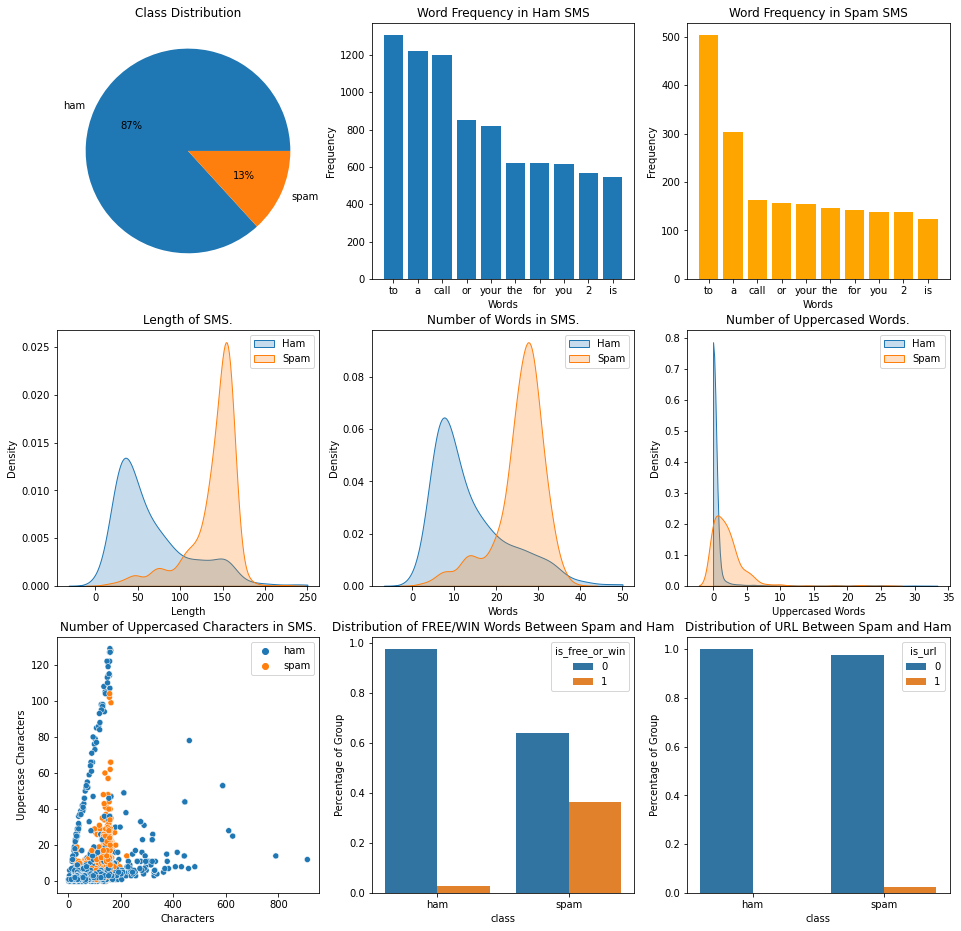

In [4]:
fig, axs = plt.subplots(3, 3, figsize =  (16,16))

# Class Distribution
class_value_counts = df['class'].value_counts(sort = True)

# Plot
axs[0,0].set_title("Class Distribution")
axs[0,0].pie(class_value_counts, labels = class_value_counts.index, autopct = "%1.0f%%")
axs[0,0].axis('off')


# Word Frequency
most_common_ham = pd.DataFrame.from_dict(
    
    Counter(" ".join(df.loc[df["class"]== "ham"]["text"]).split()).most_common(10)
)

most_common_ham = most_common_ham.rename(columns={0: "word_in_ham", 1 : "frequency"})


most_common_spam = pd.DataFrame.from_dict(
    
    Counter(" ".join(df.loc[df["class"]== "spam"]["text"]).split()).most_common(10)
)

most_common_spam = most_common_spam.rename(columns={0: "word_in_spam", 1 : "frequency"})

axs[0,1].set_title("Word Frequency in Ham SMS")
axs[0,1].bar(most_common_ham["word_in_ham"], most_common_ham["frequency"])
axs[0,1].set_xticks(np.arange(len(most_common_ham["word_in_ham"])))
axs[0,1].set_xticklabels(most_common_ham["word_in_ham"])
axs[0,1].set_xlabel("Words")
axs[0,1].set_ylabel("Frequency")

axs[0,2].set_title("Word Frequency in Spam SMS")
axs[0,2].bar(most_common_spam["word_in_spam"], most_common_spam["frequency"], color = 'orange')
axs[0,2].set_xticks(np.arange(len(most_common_spam["word_in_spam"])))
axs[0,1].set_xticklabels(most_common_spam["word_in_spam"])
axs[0,2].set_xlabel("Words")
axs[0,2].set_ylabel("Frequency")

# Length
df["message_len"] = df["text"].apply(len)

sns.kdeplot(
    df.loc[df['class'] == "ham", "message_len"],
    shade=True,
    label="Ham",
    clip=(-50, 250), ax = axs[1,0]
)
sns.kdeplot(df.loc[df['class'] == "spam", "message_len"], shade=True, label="Spam",ax = axs[1,0])
axs[1,0].set(
    xlabel="Length",
    ylabel="Density",
    title="Length of SMS.",
)
axs[1,0].legend(loc="upper right")


# Number of Words
df["nwords"] = df["text"].apply(lambda s: len(re.findall(r"\w+", s)))

sns.kdeplot(
    df.loc[df['class'] == "ham", "nwords"],
    shade=True,
    label="Ham",
    clip=(-10, 50), ax = axs[1,1]
)
sns.kdeplot(df.loc[df['class'] == "spam", "nwords"], shade=True, label="Spam", ax = axs[1,1])

axs[1,1].set(
    xlabel="Words",
    ylabel="Density",
    title="Number of Words in SMS.",
)
axs[1,1].legend(loc="upper right")


# Number of Uppercased Words
df["nupperwords"] = df["text"].apply(
    lambda s: len(re.findall(r"\b[A-Z][A-Z]+\b", s))
)
sns.kdeplot(
    df.loc[df['class'] == "ham", "nupperwords"],
    shade=True,
    label="Ham",
    clip=(0, 35), ax = axs[1,2]
)
sns.kdeplot(df.loc[df['class'] == "spam", "nupperwords"], shade=True, label="Spam", ax = axs[1,2])
axs[1,2].set(
    xlabel="Uppercased Words",
    ylabel="Density",
    title="Number of Uppercased Words.",
)
axs[1,2].legend(loc="upper right")

# Number of Uppercased Characters
df["nupperchars"] = df["text"].apply(
    lambda s: sum(1 for c in s if c.isupper())
)

sns.scatterplot(x="message_len", y="nupperchars", hue="class", data=df, ax = axs[2,0])
axs[2,0].set(
    xlabel="Characters",
    ylabel="Uppercase Characters",
    title="Number of Uppercased Characters in SMS.",
)
axs[2,0].legend(loc="upper right")


# Contains free or win
df["is_free_or_win"] = df["text"].apply(
    lambda s: int("free" in s.lower() or "win" in s.lower())
)


grouped_data = (
    df.groupby("class")["is_free_or_win"]
    .value_counts(normalize=True)
    .rename("Percentage of Group")
    .reset_index()
)

axs[2,1].set_title("Distribution of FREE/WIN Words Between Spam and Ham")

sns.barplot(
    x="class",
    y="Percentage of Group",
    hue="is_free_or_win",
    data=grouped_data, ax = axs[2,1]
)


# Contains url
df["is_url"] = df["text"].apply(
    lambda s: 1
    if re.search(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
        s,
    )
    else 0
)


grouped_data = (
    df.groupby("class")["is_url"]
    .value_counts(normalize=True)
    .rename("Percentage of Group")
    .reset_index()
)

axs[2,2].set_title("Distribution of URL Between Spam and Ham")

sns.barplot(
    x="class",
    y="Percentage of Group",
    hue="is_url",
    data=grouped_data, ax = axs[2,2]
)

plt.savefig('assets/data_analysis.jpg')
plt.show()

## 4. Data Preprocessing

In [5]:
df["text"] = df["text"].apply(
    lambda row: re.sub(r"[^a-zA-Z]+", " ", row)  
)

df["text"].head()

0    Go until jurong point crazy Available only in ...
1    SMSSERVICES for yourinclusive text credits pls...
2     p alfie Moon s Children in need song on ur mo...
3    U have a secret admirer REVEAL who thinks U R ...
4    Dear Voucher Holder To claim this weeks offer ...
Name: text, dtype: object

In [6]:
df["text"] = df["text"].apply(lambda row: word_tokenize(row))
df["text"].head()

0    [Go, until, jurong, point, crazy, Available, o...
1    [SMSSERVICES, for, yourinclusive, text, credit...
2    [p, alfie, Moon, s, Children, in, need, song, ...
3    [U, have, a, secret, admirer, REVEAL, who, thi...
4    [Dear, Voucher, Holder, To, claim, this, weeks...
Name: text, dtype: object

In [7]:
df["text"] = df["text"].apply(
    lambda row: [
        token for token in row if token not in set(stopwords.words("english"))
    ]
)
df["text"].head()

0    [Go, jurong, point, crazy, Available, bugis, n...
1    [SMSSERVICES, yourinclusive, text, credits, pl...
2    [p, alfie, Moon, Children, need, song, ur, mob...
3    [U, secret, admirer, REVEAL, thinks, U, R, So,...
4    [Dear, Voucher, Holder, To, claim, weeks, offe...
Name: text, dtype: object

In [8]:
df["text"] = df["text"].apply(
    lambda row: " ".join([WordNetLemmatizer().lemmatize(word) for word in row])
)
df["text"].head()

0    Go jurong point crazy Available bugis n great ...
1    SMSSERVICES yourinclusive text credit pls goto...
2    p alfie Moon Children need song ur mob Tell ur...
3    U secret admirer REVEAL think U R So special C...
4    Dear Voucher Holder To claim week offer PC ple...
Name: text, dtype: object

In [9]:
df.loc[df['class'] == "ham", "class"] = 0
df.loc[df['class'] == "spam", "class"] = 1

In [10]:
df.head(10)

,class,text,message_len,nwords,nupperwords,nupperchars,is_free_or_win,is_url
0,0,Go jurong point crazy Available bugis n great ...,111,20,0,3,0,0
1,1,SMSSERVICES yourinclusive text credit pls goto...,156,24,3,24,0,0
2,1,p alfie Moon Children need song ur mob Tell ur...,161,32,0,7,0,0
3,1,U secret admirer REVEAL think U R So special C...,147,28,3,24,0,0
4,1,Dear Voucher Holder To claim week offer PC ple...,152,31,2,13,0,1
5,1,Do want anytime network min text NEW VIDEO pho...,149,28,2,9,0,0
6,1,We tried contact offer New Video Phone anytime...,155,28,2,15,0,0
7,1,Last chance claim ur worth discount voucher Te...,160,31,2,16,0,0
8,1,Urgent call landline Your complimentary Ibiza ...,153,28,3,18,0,0
9,1,Today Offer Claim ur worth discount voucher Te...,158,29,1,14,0,0


In [11]:
df['class'] = df['class'].astype(np.uint8)

In [12]:
df.describe()

,class,message_len,nwords,nupperwords,nupperchars,is_free_or_win,is_url
count,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000
mean,0.132275,80.161270,16.180106,0.646138,5.679788,0.071111,0.003175
std,0.338825,60.559271,11.947438,2.551516,11.932286,0.257038,0.056260
min,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,36.000000,8.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,61.000000,12.000000,0.000000,2.000000,0.000000,0.000000
75%,0.000000,121.000000,24.000000,0.000000,4.000000,0.000000,0.000000
max,1.000000,910.000000,190.000000,32.000000,129.000000,1.000000,1.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4725 entries, 0 to 4724
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class           4725 non-null   uint8 
 1   text            4725 non-null   object
 2   message_len     4725 non-null   int64 
 3   nwords          4725 non-null   int64 
 4   nupperwords     4725 non-null   int64 
 5   nupperchars     4725 non-null   int64 
 6   is_free_or_win  4725 non-null   int64 
 7   is_url          4725 non-null   int64 
dtypes: int64(6), object(1), uint8(1)
memory usage: 263.1+ KB


In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    df["text"], df["class"], test_size=0.1, random_state = 0
)



print(f"Training data: {len(X_train)} (90%)")
print(f"Testing data: {len(X_val)} (10%)")



Training data: 4252 (90%)
Testing data: 473 (10%)


## 5. Classic ML


 K-Nearest Neighbors


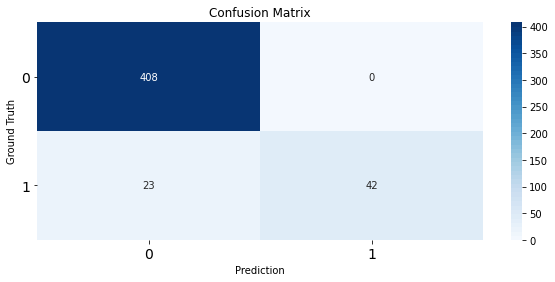

Precision: 100.000%
   Recall: 64.615%
 Accuracy: 95.137%

 Multinomial Naive Bayes


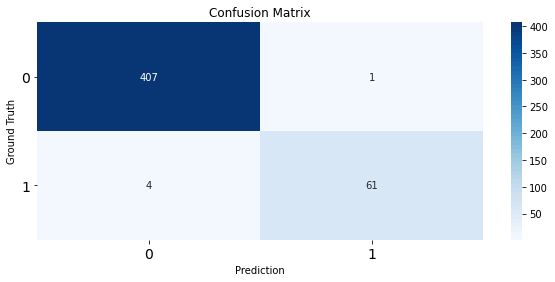

Precision: 98.387%
   Recall: 93.846%
 Accuracy: 98.943%

 Support Vector Machine


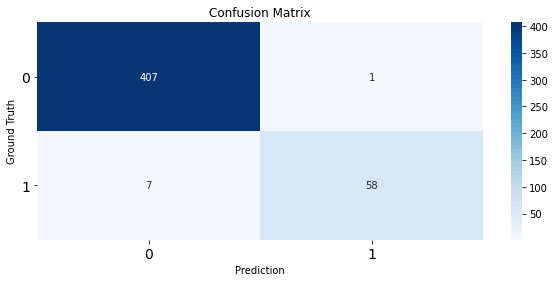

Precision: 98.305%
   Recall: 89.231%
 Accuracy: 98.309%

 AdaBoost


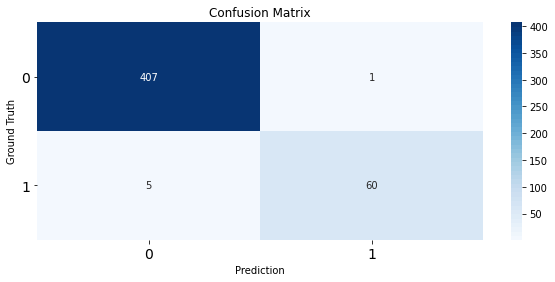

Precision: 98.361%
   Recall: 92.308%
 Accuracy: 98.732%

 Random Forest


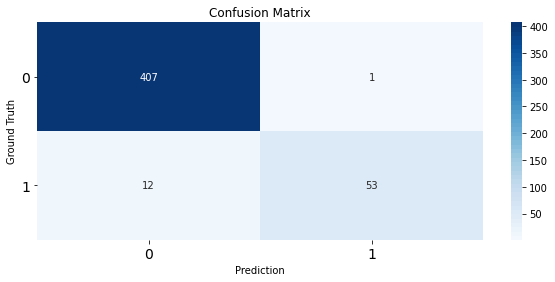

Precision: 98.148%
   Recall: 81.538%
 Accuracy: 97.252%

 XGBoost


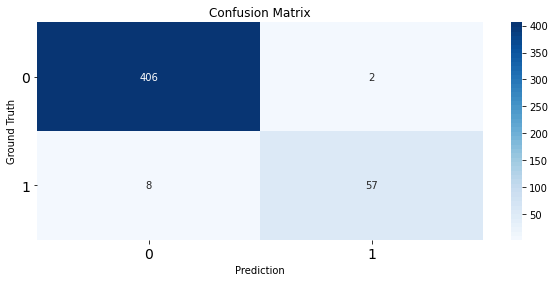

Precision: 96.610%
   Recall: 87.692%
 Accuracy: 97.886%


In [15]:


knn = GridSearchCV(
    Pipeline(
        [
            ("BagOfWords", CountVectorizer()),
            ("Tfidf", TfidfTransformer()),
            ("clf", KNeighborsClassifier())
        ]
    ),
    {
        "clf__n_neighbors": (3,5,15,25,45,55),
    }

)

mnbayes = GridSearchCV(
    Pipeline(
        [
            ("BagOfWords", CountVectorizer()),
            ("Tfidf", TfidfTransformer()),
            ("clf", MultinomialNB()),
        ]
    ),
    {
        "clf__alpha": (0.1, 1e-2, 1e-3),
        "clf__fit_prior": (True, False),
    },
)

svc = GridSearchCV(
    Pipeline(
        [
            ("BagOfWords", CountVectorizer()),
            ("Tfidf", TfidfTransformer()),
            ("clf", SVC(gamma="auto", C=1000)),
        ]
    ),
    {
        
    }
)


ada = GridSearchCV(
    Pipeline(
        [
            ("BagOfWords", CountVectorizer()),
            ("Tfidf", TfidfTransformer()),
            ("clf", AdaBoostClassifier()),
        ]
    ),
    {
        "clf__n_estimators": [100,200],
        "clf__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.5]
    }
)

rf = GridSearchCV(
    Pipeline(
        [
            ("BagOfWords", CountVectorizer()),
            ("Tfidf", TfidfTransformer()),
            ("clf", RandomForestClassifier()),
        ]
    ),
    {
        "clf__criterion" : ["gini", "entropy"],
        "clf__max_depth" :   [None, 1,3,5,10],
        "clf__min_samples_split": [5,10],
        "clf__min_samples_leaf": [5,10],
        "clf__n_estimators": [100, 150, 200]
    }
)

xgb = GridSearchCV(
    Pipeline(
        [
            ("BagOfWords", CountVectorizer()),
            ("Tfidf", TfidfTransformer()),
            ("clf", XGBClassifier()),
        ]
    ),
    {
        'clf__max_depth': [3, 4, 5],
        "clf__n_estimators": [200, 500, 600]
    }
)


models = {"K-Nearest Neighbors": knn,
          "Multinomial Naive Bayes": mnbayes,
          "Support Vector Machine": svc,
          "AdaBoost": ada,
          "Random Forest": rf,
          "XGBoost": xgb
         }

results = []

for model in models:
    
    print("\n",model)
    
    models[model].fit(X= X_train, y = y_train)
    preds = models[model].predict(X_val)
    
    plt.figure(figsize=(10,4))

    heatmap = sns.heatmap(
        data = pd.DataFrame(confusion_matrix(y_val, preds)),
        annot = True,
        fmt = "d",
        cmap=sns.color_palette("Blues", 50),
    )

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), fontsize=14)
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=14
    )

    plt.title("Confusion Matrix")
    plt.ylabel("Ground Truth")
    plt.xlabel("Prediction")
    
    plt.show()
    
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    acc = accuracy_score(y_val, preds)

    print(f"Precision: {precision * 100:.3f}%")
    print(f"   Recall: {recall * 100 :.3f}%")
    print(f" Accuracy: {acc * 100:.3f}%")
    
    results.append([model, precision, recall, acc])

## 6. LSTM

In [16]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)

In [17]:
sequences_val = tok.texts_to_sequences(X_val)
sequences_matrix_val = sequence.pad_sequences(sequences_val, maxlen = max_len)

In [18]:
def build_rnn():
    
    input_layer = layers.Input(shape = [max_len], name='Input_Layer')
    
    x = layers.Embedding(max_words, 50, input_length = max_len, name = "Embedding_Layer")(input_layer)
    x = layers.LSTM(64, activation = 'tanh', name = "LSTM_Layer")(x)
    x = layers.Dense(256, activation = 'relu', name = 'Dense_Layer_1')(x)
    #x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(1, activation='sigmoid',name = 'Output_Layer')(x)
    
    rnn = Model(inputs=input_layer, outputs=output_layer)
    
    return rnn

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 150)]             0         
_________________________________________________________________
Embedding_Layer (Embedding)  (None, 150, 50)           50000     
_________________________________________________________________
LSTM_Layer (LSTM)            (None, 64)                29440     
_________________________________________________________________
Dense_Layer_1 (Dense)        (None, 256)               16640     
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 257       
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
_________________________________________________________________


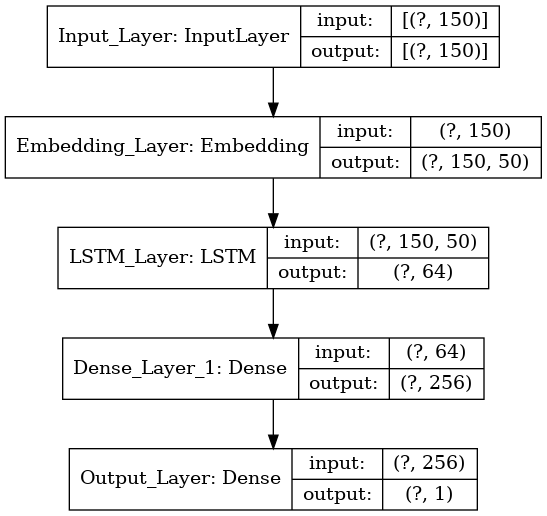

In [19]:
model = build_rnn()
model.summary()
keras.utils.plot_model(model, "assets/simple_rnn.png", show_shapes=True)

In [20]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',
              metrics =['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

In [21]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001)

In [22]:
hist = model.fit(sequences_matrix, y_train, batch_size = 128, epochs = 10,
                 validation_data=(sequences_matrix_val, y_val))

Epoch 1/10
34/34 [==============================] - 1s 21ms/step - loss: 0.4313 - accuracy: 0.8511 - precision: 0.1237 - recall: 0.0214 - val_loss: 0.2258 - val_accuracy: 0.8668 - val_precision: 1.0000 - val_recall: 0.0308
Epoch 2/10
34/34 [==============================] - 0s 10ms/step - loss: 0.1178 - accuracy: 0.9607 - precision: 0.9781 - recall: 0.7179 - val_loss: 0.0328 - val_accuracy: 0.9915 - val_precision: 0.9692 - val_recall: 0.9692
Epoch 3/10
34/34 [==============================] - 0s 10ms/step - loss: 0.0390 - accuracy: 0.9894 - precision: 0.9742 - recall: 0.9446 - val_loss: 0.0263 - val_accuracy: 0.9937 - val_precision: 0.9844 - val_recall: 0.9692
Epoch 4/10
34/34 [==============================] - 0s 10ms/step - loss: 0.0258 - accuracy: 0.9934 - precision: 0.9926 - recall: 0.9571 - val_loss: 0.0269 - val_accuracy: 0.9915 - val_precision: 0.9692 - val_recall: 0.9692
Epoch 5/10
34/34 [==============================] - 0s 10ms/step - loss: 0.0166 - accuracy: 0.9958 - precisi

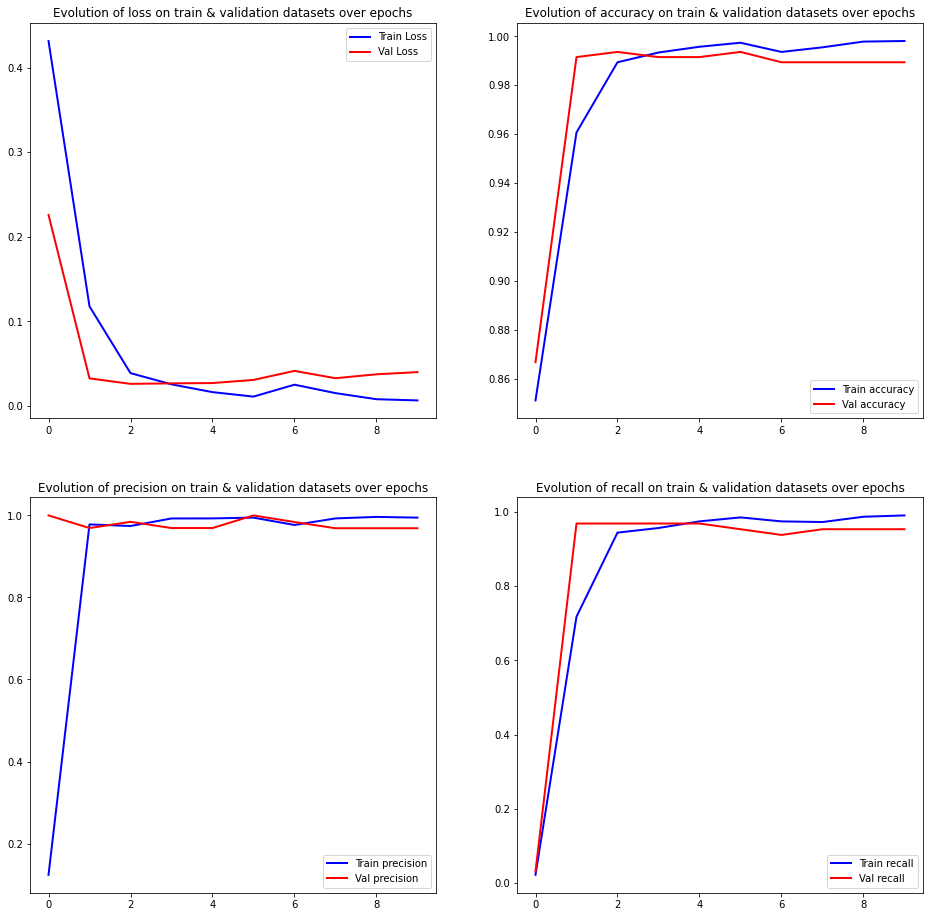

<Figure size 1440x432 with 0 Axes>

In [23]:
epoch_loss = hist.history['loss']
epoch_val_loss = hist.history['val_loss']

epoch_acc = hist.history['accuracy']
epoch_val_acc = hist.history['val_accuracy']

epoch_precision = hist.history['precision']
epoch_val_precision = hist.history['val_precision']

epoch_recall = hist.history['recall']
epoch_val_recall = hist.history['val_recall']


fig, axs = plt.subplots(2,2, figsize = (16,16))

plt.figure(figsize=(20,6))

axs[0,0].plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
axs[0,0].plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
axs[0,0].set_title('Evolution of loss on train & validation datasets over epochs')
axs[0,0].legend(loc='best')


axs[0,1].plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train accuracy')
axs[0,1].plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2,label='Val accuracy')
axs[0,1].set_title('Evolution of accuracy on train & validation datasets over epochs')
axs[0,1].legend(loc='best')


axs[1,0].plot(range(0,len(epoch_precision)), epoch_precision, 'b-', linewidth=2, label='Train precision')
axs[1,0].plot(range(0,len(epoch_val_precision)), epoch_val_precision, 'r-', linewidth=2, label='Val precision')
axs[1,0].set_title('Evolution of precision on train & validation datasets over epochs')
axs[1,0].legend(loc='best')


axs[1,1].plot(range(0,len(epoch_recall)), epoch_recall, 'b-', linewidth=2, label='Train recall')
axs[1,1].plot(range(0,len(epoch_val_recall)), epoch_val_recall, 'r-', linewidth=2,label='Val recall')
axs[1,1].set_title('Evolution of recall on train & validation datasets over epochs')
axs[1,1].legend(loc='best')

plt.show()

In [24]:
preds = model.predict(sequences_matrix_val)
preds = np.uint8(np.round(preds.T))

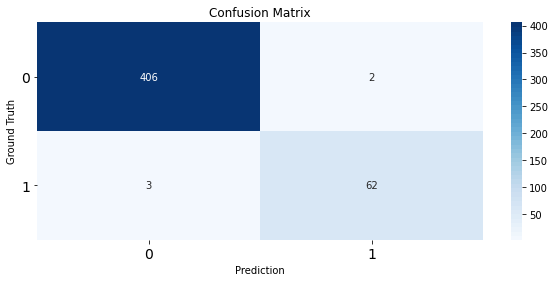

Precision: 96.875%
   Recall: 95.385%
 Accuracy: 98.943%


In [25]:
plt.figure(figsize=(10,4))

heatmap = sns.heatmap(
    data = pd.DataFrame(confusion_matrix(y_val.values, preds[0])),
    annot = True,
    fmt = "d",
    cmap=sns.color_palette("Blues", 50),
)

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), fontsize=14)
heatmap.yaxis.set_ticklabels(
    heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=14
)

plt.title("Confusion Matrix")
plt.ylabel("Ground Truth")
plt.xlabel("Prediction")

plt.show()

precision = precision_score(y_val.values, preds[0])
recall = recall_score(y_val.values, preds[0])
acc = accuracy_score(y_val.values, preds[0])

print(f"Precision: {precision * 100:.3f}%")
print(f"   Recall: {recall * 100 :.3f}%")
print(f" Accuracy: {acc * 100:.3f}%")

results.append(['Simple RNN', precision, recall, acc])

In [26]:
model.save(f'saved_models/my_model_{time.time()}.h5')

In [27]:
df_results = pd.DataFrame(results, columns=['Algorithm', 'Precision', 'Recall', 'Accuracy'])

In [28]:
df_results

,Algorithm,Precision,Recall,Accuracy
0,K-Nearest Neighbors,1.000000,0.646154,0.951374
1,Multinomial Naive Bayes,0.983871,0.938462,0.989429
2,Support Vector Machine,0.983051,0.892308,0.983087
3,AdaBoost,0.983607,0.923077,0.987315
4,Random Forest,0.981481,0.815385,0.972516
5,XGBoost,0.966102,0.876923,0.978858
6,Simple RNN,0.968750,0.953846,0.989429


## Evaluating the test

In [29]:
TEST_PATH = 'TestSet/sms-hamspam-test.csv'

df_test = pd.read_csv(TEST_PATH,names = ['text'])
df_test

,text
0,I know that my friend already told that.
1,It took Mr owl 3 licks
2,Dunno y u ask me.
3,K.k:)advance happy pongal.
4,I know but you need to get hotel now. I just g...
...,...
842,Booked ticket for pongal?
843,Yes :)it completely in out of form:)clark also...
844,Yeah sure
845,He is there. You call and meet him


In [30]:
def apply_data_preprocessing(dataframe, column):
    
    df = dataframe.copy()
    
    df[column] = df[column].apply(
        lambda row: re.sub(r"[^a-zA-Z]+", " ", row)  
    )
    
    df[column] = df[column].apply(lambda row: word_tokenize(row))
    
    df[column] = df[column].apply(
        lambda row: [
            token for token in row if token not in set(stopwords.words("english"))
        ]
    )
    
    df[column] = df[column].apply(
        lambda row: " ".join([WordNetLemmatizer().lemmatize(word) for word in row])
    )
    
    X = df[column].values
    
    max_words = 1000
    max_len = 150
    tok = Tokenizer(num_words=max_words)
    tok.fit_on_texts(X)
    sequences = tok.texts_to_sequences(X)
    sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)
    
    return sequences_matrix

In [31]:
def classify(text_csv, column, model_path):
    
    df_test = pd.read_csv(text_csv,names = [column])
    
    sequences_matrix = apply_data_preprocessing(df_test, column)
    
    model = tf.keras.models.load_model(model_path)
    
    preds = model.predict(sequences_matrix)
    preds = np.uint8(np.round(preds.T))
    preds = preds[0]
    
    df_test['class'] = preds
    
    return df_test

In [32]:
df_test = classify(TEST_PATH, 'text', 'saved_models/my_model_1607193063.6456642.h5')

In [33]:
df_test.to_csv(f'results/test_prediction{time.time()}.csv', index = False)

## 7. References

* [SMS Spam Detection - Kaggle notebooks](https://www.kaggle.com/uciml/sms-spam-collection-dataset/notebooks)